In [22]:
# Read from Datasets/ECG5000/ECG5000_TEST.txt

import numpy as np
import matplotlib.pyplot as plt

# Read from Datasets/tecator.txt
data = np.genfromtxt('Datasets/tecator.txt', delimiter=' ')

print(data.shape)

# Combine index 0 - 24 into one row
data_new = []
data_new.append(data[0:25])

data_new = np.array(data_new)
data_new = data_new.reshape(1, 125)

print(data_new.shape)

tecator = []

for i in range(140):
    data_new = []
    data_new.append(data[25*i:(25*i)+25])
    data_new = np.array(data_new)
    data_new = data_new.reshape(1, 125)
    tecator.append(data_new)

# Save the last three values from each row 
fat_percentage = []
for i in range(len(tecator)):
    fat_percentage.append(tecator[i][:, -2])
    tecator[i] = tecator[i][:, :-25]

(6000, 5)
(1, 125)


In [23]:
# Assign true_labels to be 1 if the fat percentage is greater than 20, otherwise 0
true_labels = []
for i in range(len(fat_percentage)):
    if fat_percentage[i] > 20:
        true_labels.append(1)
    else:
        true_labels.append(0)

In [24]:
# Make teacator into a numpy array
tecator = np.array(tecator)

# Change the shape of the data from (140, 1, 122) to (140, 122)
tecator = tecator.reshape(140, 100)

# Get the first order derivative of the data
tecator = np.diff(tecator, axis=1)


Text(0, 0.5, 'Absrbance')

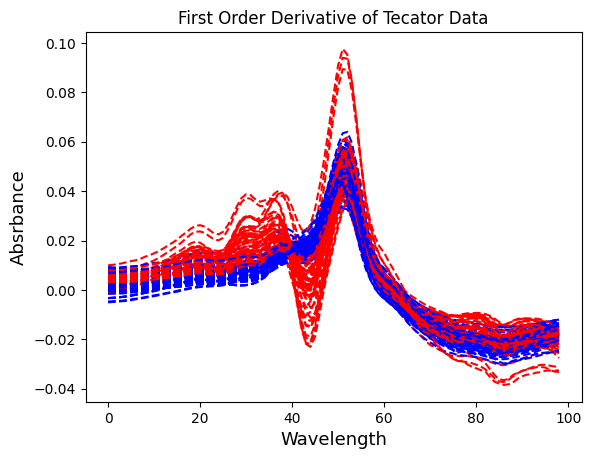

In [43]:
# Plot the tecaor data based on the true labels
for i in range(len(tecator)):
    if true_labels[i] == 1:
        plt.plot(tecator[i], '--r')
    else:
        plt.plot(tecator[i], '--b')
plt.title((
    'First Order Derivative of Tecator Data'))
plt.xlabel('Wavelength', fontsize=13)
plt.ylabel('Absrbance', fontsize=13)

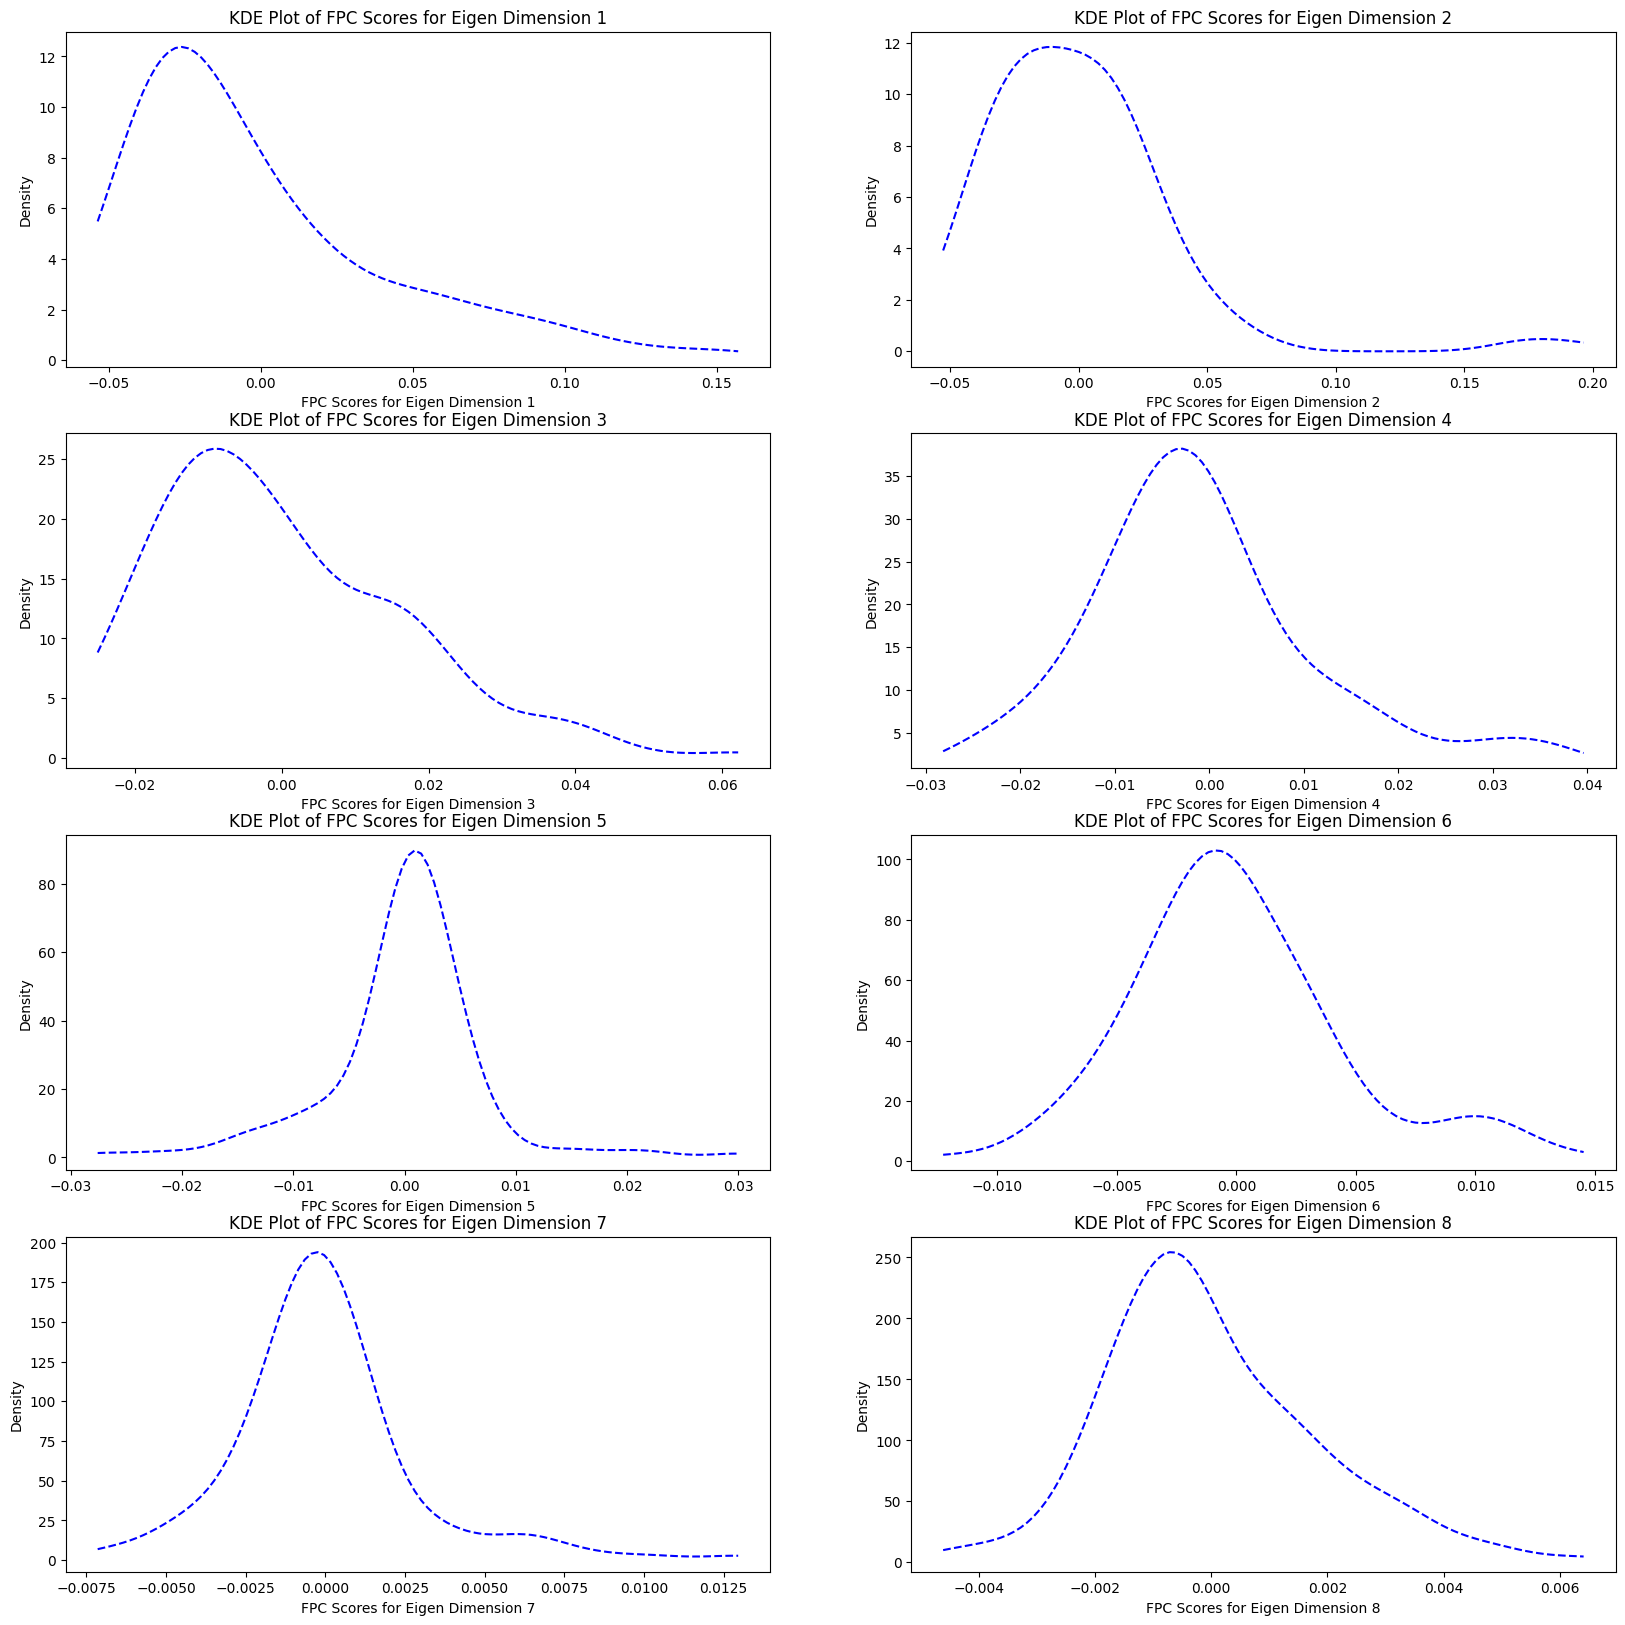

In [26]:
import scipy
from scipy import spatial, interpolate
from ensemble_clustering import functional_data_decomposition, functional_data_clustering
from fda_results import percentage_variation_ami_ari, plot_percentage_variation_ami_ari

data = tecator

data_smooth, mean, principal_componenets, eigen_functions = functional_data_decomposition (data, 10, 150)

# For loop to plot a 2x2 set of scatter plots for the kernel density plots of the first four principal components
fig, ax = plt.subplots(4, 2, figsize=(20, 20))
for i in range(8):
    # Kernel density plot for principal components[i], as a scatter plot
    # Determine the desnity of principal components[i]
    kde = scipy.stats.gaussian_kde(principal_componenets[:,i])
    # Create a grid of points
    x_grid = np.linspace(min(principal_componenets[:,i]), max(principal_componenets[:,i]), 100)
    # Evaluate the density on the grid
    density = kde(x_grid)
    # Plot the density
    ax[i//2, i%2].plot(x_grid, density, color='b', linestyle='--')
    ax[i//2, i%2].set_title('KDE Plot of FPC Scores for Eigen Dimension ' + str(i+1))
    ax[i//2, i%2].set_xlabel('FPC Scores for Eigen Dimension ' + str(i+1))
    ax[i//2, i%2].set_ylabel('Density')
plt.show()

Percentage of variation explained by each eigen dimensions:  [4.96807141e-01 3.64736349e-01 7.13846862e-02 4.57468347e-02
 1.24984821e-02 5.23731534e-03 2.09497879e-03 8.59045189e-04
 3.90943286e-04 2.44224469e-04]


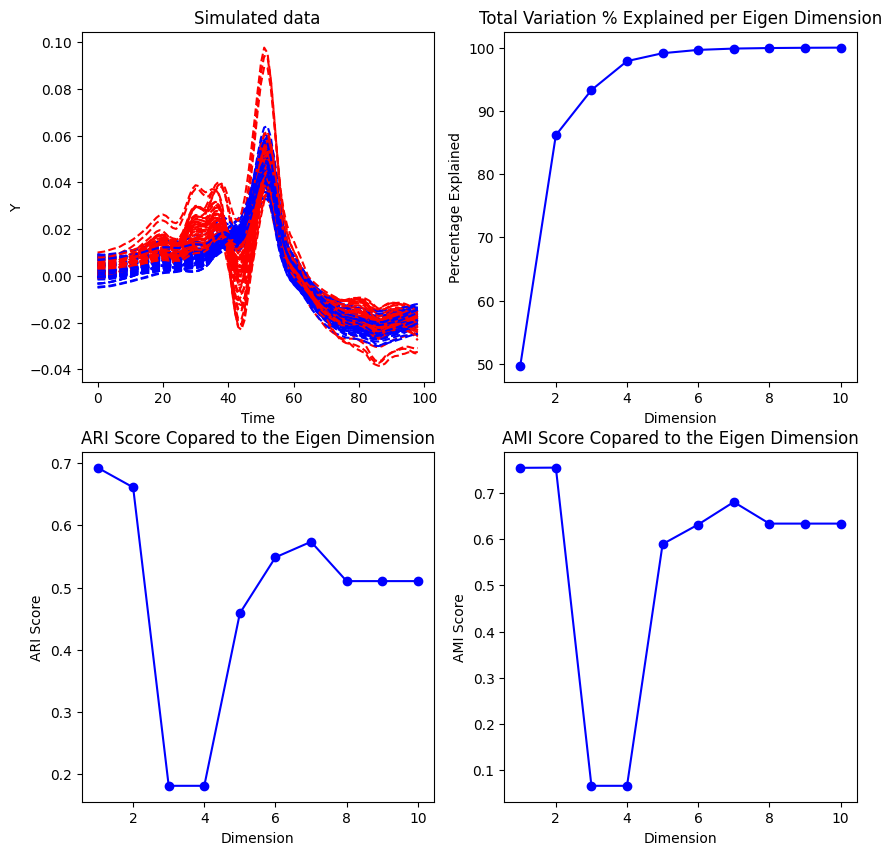

In [27]:
variance, ami, ari, v_range = percentage_variation_ami_ari(10, data, 150, true_labels, 2)
plot_percentage_variation_ami_ari(variance, ami, ari, v_range, true_labels, data)

In [28]:
# Determine the Eigen Dimension that explains 95% of the variance
for i in range(len(variance)):
    if sum(variance[:i]) >= 0.95:
        print('The Eigen Dimension that explains 95% of the variance is ' + str(i))
        V = i -1
        if V == 0:
            V = 1
        break

The Eigen Dimension that explains 95% of the variance is 4


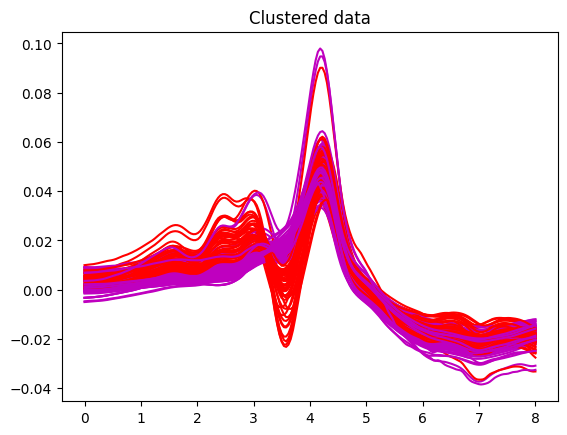

AMI score: 0.713629
ARI score: 0.806876


In [29]:
# Get data from the first function
data_smooth, mean, principal_componenets, eigen_functions = functional_data_decomposition (data, V, 200)

# Get data from the second function
membership_matrices, labels = functional_data_clustering (principal_componenets, 2)

# Plot the curves with their labels
t = np.expand_dims(np.linspace(0, 8, len(data_smooth[0])), 1)
for i in range(len(data_smooth)):
    if labels[i] == 0:
        plt.plot(t, data_smooth[i], '-m')
    else:
        plt.plot(t, data_smooth[i], '-r')
plt.title('Clustered data')
plt.show()

from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score

print("AMI score: %f" % adjusted_mutual_info_score(true_labels, labels))
print("ARI score: %f" % adjusted_rand_score(true_labels, labels))

In [30]:
from FDApy.clustering.fcubt import Node, FCUBT
from FDApy.representation.functional_data import DenseFunctionalData

# Ignore the warning
import warnings
warnings.filterwarnings("ignore")

# Make t a dict
t = np.expand_dims(np.linspace(0, 20, len(data[0])), 1)
t = {'input_dim_0': t}
# Change t from (100, 1) to (100,)
t = {k: v.squeeze() for k, v in t.items()}

fcubt_data = DenseFunctionalData(t, data)
# Build the tree
root_node = Node(fcubt_data, is_root=True)
fcubt = FCUBT(root_node=root_node)

# Growing
fcubt.grow(n_components=0.95, min_size=10)

# Joining
fcubt.join(n_components=0.95)

# Get the ARI
print("ARI score for FCUBT: %f" % adjusted_rand_score(true_labels, fcubt.labels_join))
# Get the AMI
print("AMI score for FCUBT: %f" % adjusted_mutual_info_score(true_labels, fcubt.labels_join))

ARI score for FCUBT: 0.272792
AMI score for FCUBT: 0.243245


In [31]:
# Store the data in DataStore.csv
np.savetxt('Data/DataStore.csv', data, delimiter=',')

In [32]:
import os
os.environ["R_HOME"] = r"C:\Program Files\R\R-4.2.2" # change as needed

%reload_ext rpy2.ipython

In [37]:
# Perform FunFEM on the data

# Load packages
%R library(fda)
%R library(funHDDC)
%R library(mclust)
%R library(tidyverse)

# # Load data
%R argvals <- seq(0, 1, length.out = 99)
%R values <- t(as.matrix(read.csv('~/ProjectDocs/Project_code/simuations/Data/DataStore.csv', header = FALSE))) # nolint

# FunHDDC
%R basis <- create.bspline.basis(rangeval = c(min(argvals), max(argvals)), nbasis = 25, norder = 3) # nolint

%R data_fd <- smooth.basis(argvals = argvals, y = values, fdParobj = basis)$fd
%R res_clust <- funHDDC(data_fd, K = 2, threshold = 0.3, model = 'ABQkDk',  itermax = 2000, eps = 1e-3, init = 'kmeans') # nolint
%R pred_labels <- res_clust$class

# %R print(pred_labels)

# Write the pred_labels to a file
%R write.csv(pred_labels, file = '~/ProjectDocs/Project_code/simuations/Data/PredictedLabelsStore.csv') # nolint

   model K threshold complexity        BIC
1 ABQKDK 2       0.3        190 -20,926.83

SELECTED: model  ABQKDK  with  2  clusters.
Selection Criterion: BIC.


In [38]:
# Read Labels from PredictedLabels.csv, ignoring the header and the first column
predicted_labels = np.genfromtxt('Data/PredictedLabelsStore.csv', delimiter=',', skip_header=1, usecols=1)
print("ARI score for funHDDC: %f" % adjusted_rand_score(true_labels, predicted_labels))
print("AMI score for funHDDC: %f" % adjusted_mutual_info_score(true_labels, predicted_labels))

ARI score for funHDDC: 0.680007
AMI score for funHDDC: 0.590963


In [40]:
# Load packages
%R library(fda)
%R library(funFEM)
%R library(mclust)
%R library(tidyverse)

# Load data
%R argvals <- seq(0, 1, length.out = 99)
%R values <- t(as.matrix(read.csv('~/ProjectDocs/Project_code/simuations/Data/DataStore.csv', header = FALSE))) # nolint

# FunHDDC
%R basis <- create.bspline.basis(rangeval = c(min(argvals), max(argvals)), nbasis = 25, norder = 3) # nolint
%R data_fd <- smooth.basis(argvals = argvals, y = values, fdParobj = basis)$fd
%R res_clust = funFEM(data_fd,K=2, model='AkjB') # nolint # nolint: commas_linter.
%R pred_labels <- res_clust$P

# %R print(pred_labels)

# Write the pred_labels to a file
%R write.csv(pred_labels, file = '~/ProjectDocs/Project_code/simuations/Data/PredictedLabelsStore.csv') # nolint


In [42]:
# Read labels from PredictedLabels.csv, ignoring the header and the first column and getting the first four columns
predicted_labels = np.genfromtxt('Data/PredictedLabelsStore.csv', delimiter=',', skip_header=1, usecols=range(1, 3))
#   Format the labels
labels = np.zeros(len(predicted_labels))
for i in range(len(predicted_labels)):
    labels[i] = np.argmax(predicted_labels[i])
print("ARI score for funFEM: %f" % adjusted_rand_score(true_labels, labels))
print("AMI score for funFEM: %f" % adjusted_mutual_info_score(true_labels, labels))


ARI score for funFEM: 0.399280
AMI score for funFEM: 0.293357
